In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import pandas as pd
import sys
sys.path.append("./../../p-det-O3/")
from p_det_O3.emulator import p_det_O3
import pickle
from scipy.stats import ks_2samp
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
np.random.seed(190521)
from figure_utilities import gen_found,make_hist

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
ann = p_det_O3(model_weights="./../data/trained_model_tests/wrapper_draft_releas_additionalPops_batch_1024_lr_1e-4_altRatios_linearMasses_fullEvents/job_27_weights.hdf5",
                scaler="./../data/trained_model_tests/wrapper_draft_releas_additionalPops_batch_1024_lr_1e-4_altRatios_linearMasses_fullEvents/job_27_input_scaler.pickle")

jitted_ann = jax.jit(ann)

In [3]:
# NSBH params
nsbh_found,nsbh_nTrials = gen_found(jitted_ann,
                                    10000,
                                    min_m1=2.5,
                                    max_m1=60.,
                                    alpha_m1=-2.35,
                                    min_m2=1.,
                                    max_m2=2.5,
                                    alpha_m2=0.,
                                    max_a1=0.998,
                                    max_a2=0.4,
                                    zMax=0.25,
                                    kappa=0.,
                                    conditional_mass=False)

In [4]:
def addDerived(data):

    data['amp_factor_a'] = np.log((data.chirp_mass_detector**(5./6.)/data.luminosity_distance*((1.+data.cos_inclination**2)/2))**2)
    data['amp_factor_b'] = np.log((data.chirp_mass_detector**(5./6.)/data.luminosity_distance*data.cos_inclination)**2)
    data['log_m1'] = np.log(data.m1_detector)
    data['log_Mc'] = np.log(data.chirp_mass_detector)
    data['log_Mtot'] = np.log(data.total_mass_detector)
    data['log_d'] = np.log(data.luminosity_distance)
    data['scaled_eta'] = np.log(0.25-data.eta)
    data['sin_declination'] = np.sin(data.declination)
    data['abs_cos_inclination'] = np.abs(data.cos_inclination)
    data['one_plus_z'] = 1.+data.redshift
    data['cos_pol'] = np.cos(data.polarization%np.pi)
    data['sin_pol'] = np.sin(data.polarization%np.pi)
    data['m1_source'] = data.m1_detector/(1.+data.redshift)
    data['Xdiff_PN'] = (data['a1']*data['cost1'] - data['a2']*data['cost2'])/2.

# Load reference training data and extract detections
nsbh_reference_data = pd.read_hdf("./../data/training_data/nsbh_training_data.hdf")

addDerived(nsbh_reference_data)

nsbh_reference_found = nsbh_reference_data[nsbh_reference_data.detected==1]

In [5]:
# NSBH params
raw_nsbh,raw_nsbh_nTrials = gen_found(lambda x: np.ones(x.shape[1]),
                                    100000,
                                    min_m1=2.5,
                                    max_m1=60.,
                                    alpha_m1=-2.35,
                                    min_m2=1.,
                                    max_m2=2.5,
                                    alpha_m2=0.,
                                    max_a1=0.998,
                                    max_a2=0.4,
                                    zMax=0.25,
                                    kappa=0.,
                                    conditional_mass=False)

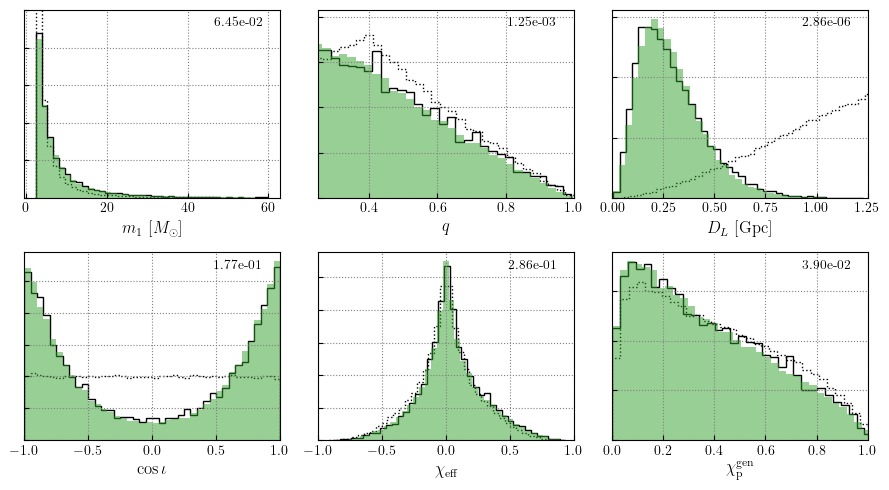

In [6]:
fig = plt.figure(figsize=(9,5))

nBins = 40

ax = fig.add_subplot(231)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'m1_source',color=cnsbh,
          ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
          ylim=(0,0.25),#xlim=(1,2.5),
          label=r"$m_1\,\,[M_\odot]$")

ax = fig.add_subplot(232)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'q',color=cnsbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0.25,1),
         label=r"$q$")

ax = fig.add_subplot(233)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'luminosity_distance',color=cnsbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0,1.25),#ylim=(0,0.4),
         label=r"$D_L\,\,[\mathrm{Gpc}]$")

ax = fig.add_subplot(234)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'cos_inclination',color=cnsbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(-1,1),#ylim=(0,1.5),
         label=r"$\cos\iota$")

ax = fig.add_subplot(235)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'Xeff',color=cnsbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(-1.,1.),#ylim=(0,2.2),
         label=r"$\chi_\mathrm{eff}$")

ax = fig.add_subplot(236)
make_hist(ax,nsbh_reference_found,nsbh_found,raw_nsbh,'Xp_gen',color=cnsbh,
         ref_bins=nBins,new_bins=nBins,raw_bins=nBins,
         xlim=(0,1.),#ylim=(0,1.5),
         label=r"$\chi_\mathrm{p}^{\rm gen}$")

plt.tight_layout()
plt.savefig('figure_05.pdf',bbox_inches='tight')